# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=(2**16),alternate_sign=False, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data["comment_text"].str.count("\!")

    X_quant_features = toxic_data[["word_count", "punc_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 6437, 'TN': 57900, 'FP': 56754, 'FN': 6565, 'Accuracy': 0.5039872783104593, 'Precision': 0.10186577202449716, 'Recall': 0.49507768035686817, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [54]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=0.00001)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12976, 'TN': 114641, 'FP': 13, 'FN': 26, 'Accuracy': 0.9996944914457605, 'Precision': 0.9989991531295712, 'Recall': 0.9980003076449777, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12984, 'TN': 114635, 'FP': 19, 'FN': 18, 'Accuracy': 0.9997101585511061, 'Precision': 0.9985387987387526, 'Recall': 0.9986155976003692, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12196, 'TN': 106283, 'FP': 8371, 'FN': 806, 'Accuracy': 0.9281114871216394, 'Precision': 0.5929887684154228, 'Recall': 0.9380095369943086, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12978, 'TN': 114635, 'FP': 19, 'FN': 24, 'Accuracy': 0.9996631572350693, 'Precision': 0.9985381241825037, 'Recall': 0.9981541301338256, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12576, 'TN': 114605, 'FP': 49, 'FN': 426, 'Accuracy': 0.9962790624804161, 'Precision': 0.9961188118811881, 'Recall': 0.9672358098754038, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 0, 'TN': 114654, 'FP': 0, 'FN': 13002, 'Accuracy': 0.8981481481481481, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/isabelstoddart/Desktop/ML/myWork/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

In [12]:
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: train set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
28
Kingdom under Fire

Please don't make reverts to articles with misleading edit summaries as you did here http://en.wikipedia.org/w/index.php?title=Kingdom_Under_Fire_II&action;=historysubmit&diff;=479144243&oldid;=473726155

It's quite clear that your edit was a retrograde step as it removed proper formatting applied to a reference, and reintroduced  unreferenced information that was previously removed because it could not be verified because the game had not been released.
* * * * * * * * * 
70
" — Preceding unsigned comment added by  (talk • contribs) 
Are you referring to the Orphan tag at the top of the article? That says that too few articles link to this one.  arfcontribs. "
* * * * * * * * * 
103
"

 Request help with charts 

Hey, Hahc21. Since I know you to be a chart master I was wondering if you could find the time to take a look at the charts in the Sgt. Pepper's Lonely Hearts Club Band article. Cheers!  (talk|contribs)  
Sure. I'll take a lo

2251
Thank you for adding your perspective, I think I understand your point (by nothing to sneeze at I took as meaning not a big deal) but it's more a matter of principle. Am I being blocked for asking someone to focus on the article's issues or for saying that person has a COI? I don't mean to sound indignant but either way there are other ways of handling things, but at least I should know what the deal is.

I mean the blocking admin accused me of making ad hominem attacks, which I have most certainly not (especually if one goes by the definition in the wikilink: An ad hominem argument, consists of replying to an argument or factual claim by attacking or appealing to a characteristic or belief of the person making the argument or claim, It'd be nice to know what exactly this admin saw as one.
* * * * * * * * * 
2254
I was suspended for 31 hours.  Anyway, I'm someone reputable, but I'd rather not associate my real identity with my wikipedia account, since I'm kinda being a jerk with t

3433
Too late Gamaliel has threatend a revert war on Joe Scarborough. Check out http://en.wikipedia.org/wiki/User_talk:Gamaliel#Joe_Scarbourough
* * * * * * * * * 
3483
"

Izehar's RfA
Hi Elliskev,
I would like to thank you for your kind support on my RfA. I'll do my best to be a good administrator. If you need anything or if I ever do something I shouldn't have, please, don't hesitate to drop me a line.  "
* * * * * * * * * 
3503
"for example that content reports ""he lead the armies into kashmir"" in short sikhs have made him commander of the expedition , i have given sources in the talk that the leadership was with Diwan Misr Chand and not with Hari Singh but as you have seen these millitant sikhs have started distorting history here and their and will claim we are bravest , no one objects but atleast dont distort history i have given sources in talk section of hari singh page , kashmir campaign was under misr chand not under any sikh.their is no doubt this is no ancient history thi

5322
Harassment? 

Well, beats sock - don't it? ^_^
* * * * * * * * * 
5337
This page should not be speedy deleted because...  

This page should not be speedily deleted because... Mike Boich is Apple's 1st Evangelist for the Macintosh. This make no sense to delete him. You can delete what seems like promotion, but there is not reason to delete the entry for Mike Boich.
* * * * * * * * * 
5343
July 2009
In Insurance you have contributed some potentially useful information but have phrased it as an argument with the contributions of other editors. That type of discourse is normally reserved for the talk pages with the article itself reserved for consensus information on the topic. Evidently there is a lack of consensus on the use of call centers in the insurance business and a need for further discussion. There are two main approaches that are usually taken in this case: 1) edit the article to include your information and see if anyone objects and/or reverts your edits  and then discuss

6459
Norwegian schools
Sorry for the delay in replying. I've only just seen your comments on the Norwegian schools. I was expecting a reply on my talk page! We've developed the criteria for assessing schools as we've gone along. It probably doesn't make that much difference if a school is top or high, but the idea is to have at least one top importance school from each country. So far we've found the alumni to be one of the most effective ways to judge a school's importance but the system is inevitably subjective. These three Norwegian schools are amongst the oldest in the world and there might well be a case for making them all top importance, especially if they were indeed the only schools in the country for many centuries. It's very difficult to compare the three, especially when the articles are so short. I think it might be best to wait until the articles have been expanded and then request a re-assessment.
* * * * * * * * * 
6489
"

 Yuri Stern 

I looked over the article, and it

8186
Vandalism 

Thank you for experimenting with Wikipedia, your test worked and it has been removed or reverted. Please do not add nonsense to articles or remove content added by other users. This is considered vandalism, if you continue to vandalize Wikipedia you will be banned. If you'd like to experiment with Wikipedia use the Sandbox
* * * * * * * * * 
8204
"

 Bradykinin 

Nice call on the bradykinin/Brady Bunch thing, it was actually vandalism. Bradykinin actually gets its name from the Greek brady (meaning ""slow"", as in bradycardia).  "
* * * * * * * * * 
8317
Yes, I understand. But it was fun.
* * * * * * * * * 
8375
What would be really useful is references to critical appraisal from a magazine/journal of some standing. This is probably less easy to locate, though, for an artist whose work focus is outside the gallery. I was going to have a look myself later and will add if I find anything, but not necessarily holding out any hope.
* * * * * * * * * 
8435
spamspamspmspam 


9740
. Plus I want an spi and not be blocked straight off unfairly, user acted too harshly and swiftly
* * * * * * * * * 
9746
Do you think it should be closed?   ☎
* * * * * * * * * 
9748
Thanks for doing all that cleanup work.
* * * * * * * * * 
9750
(reply:) please use appropriate language at wikipedia.
* * * * * * * * * 
9767
"

Receiving money from KGB (edit request)
Rajiv Gandhi and his family including Sonia Gandhi and Rahul Gandhi received money from KGB. The payments were authorised by a resolution and endorsed by the USSR Council of Ministers, and had been coming since 1971. In December 2001, Subramanian Swamy filed a writ petition in the Delhi High Court, acting on which the court ordered CBI to ascertain the truth of the allegations in May 2002. After two years, the CBI told the Court that Russia would not entertain such queries without a registered FIR.

Since the Rajiv Gandhi (former PM of India) page mentions the above, this should be mentioned on Rahul's page too. This 

11134
I've informed with a friend of mine, he looked it up and though Babelfish does indeed say dream, the dictionary says:
1. Something apparently seen but having no physical reality; a phantom or an apparition. Also called phantasma.
So, alas (I like different Japanese names for Zelda games), it's a direct translation.
* * * * * * * * * 
11167
Movement of ranking out of lead 

I moved the rankings from the lead into the Rankings and Admission section of the body.  Honestly, the rankings are a completely useless and subjective metric and placing it in the lead is giving them undue weight.
* * * * * * * * * 
11182
"
It seems the process requires a deletion nomination through the Redirects for Discussion page.  I have linked the nomination to our discussion here. Talk "
* * * * * * * * * 
11190
"

 Help 

Hello. I need your help with something. I see that you've been making these Amazing Race maps lately. This being an example > . Can you pliss pliss pliss make one for me or at least te

12493
Returned to abovementioned talk page about Leviticus 16
* * * * * * * * * 
12501
Was it? I guess you'd have to read the edit to be sure. I'm certain if it was an attack it was vicious, scathing, and completely baseless. He does seem to clearly be more interested in vandalism than improving Wikipedia while having a sense of humor. 69.105.172.180
* * * * * * * * * 
12581
That is very and disrepectful rude of you.
* * * * * * * * * 
12626
"
Why should the name be shortened? ""BMW"" is hardly a long word. The FIA refused permission for the name change, and thus the team did not change it, so it must therefore be seen to be wrong to remove the ""BMW"" part of the name. It may ""essentially"" be a return to pre-BMW Sauber, but officially, it isn't. And that's all that matters. Also, I reiterate, it is unverifiable.   "
* * * * * * * * * 
12675
, what kikichugirl meant is that if you look at the page, the majority of the content is above the Table of Contents. She was requesting that yo

13972
Hi!  The link to MSNBC  on the Reperfusion page is redirecting to http://www.newsweek.com.  Not sure why or how the correct link can be found, perhaps you can help?  Thanks!
* * * * * * * * * 
13994
"
OK - well take a look at the edit history of these pages.  Until today (the last 10 mins or so) I had not edited any of them so I think you have the wrong person. However as you've drawn my attention to them thanks as I've removed links that are to a ""fake"" site according to McAfee site advisor.  If I can help more - fine - but I don't think it's me you are after   (Talk) "
* * * * * * * * * 
14201
"

Well if you want to sincerely discuss it I can make an exception as I have the expertise and have some time so I ask you first to consider the full context of the selections you outline. The Aurobindo letter begins: ""All these experiences are of the same nature and what applies to one applies to another. Apart from some experiences of a personal character, the rest are either idea-t

15670
"

do you understand that you are absolutely prohibited from posting the link to MyHotels which you have posted and been blocked for posting?""talk"" "
* * * * * * * * * 
15673
i have no life i edit wikipedia
* * * * * * * * * 
15778
Basically I dont entirely agree that the gourman report debate has been exhausted (or some others). Tell anyone that in the opening paragraph the wikipedia article of U of O has to reference a ten year old ranking to make it look good is laughable (Queens, Carleton, waerloo etc alumni eat this up).
If you check current rankings of world debating youll find the univeristy of ottawa ranks mid 70 or so. True its on other universities pages but they also mention the current world ranking in most (sydney does this i belive as well as toronto). Also other university pages are not the best for POV and reputation anyway so to say its on one page and not on another really isnt the best argument. The article is swayed to the point of view that makes it look be

18418
Re: Template:Islam and China 

Hi there!

Don't worry, I will help you because as I can see that you was right and I totally support it. Have a nice day. Bye.
* * * * * * * * * 
18466
I don't understand your point. Is it that there are other publications on the planet Earth that do not have a neutral POV, so therefore Wikipedia should not have a neutral POV when the subject is Martin Luther? That appears to be what you are saying.
* * * * * * * * * 
18490
info for your curiosity

Credibility_node_ue
* * * * * * * * * 
18539
"

 Bigg Boss 7 

I have rewritten the whole summary. If you still think it violates the copy-vio code please provide evidence. Copy-vio info shall not be added in future. I've removed the template since no investigation is required. The issue is settled. Cheers.  chat  "
* * * * * * * * * 
18635
17:32, February 10, 2006

 Could you be more specific as to what is point of view?
* * * * * * * * * 
18751
its funny how Zora keeps over looking this transgression.


19594
somebody should add g unit south or cashville records because evidently somebody thinks there is a cashville records because they created the official website.
* * * * * * * * * 
19625
|Afd nomination of]] Julie-Su
* * * * * * * * * 
19648
I made a contribution to ROSALIA DE CASTRO
Also to SPANISH INQUISITION
  

ello
* * * * * * * * * 
19782
"

 U.S. in title, US in article 

Any reason this shouldn't be moved to List of US Highways in Michigan to be consistent with all the usages of ""US Highway"" within the article?   "
* * * * * * * * * 
19833
"::::Excellent )^ Yaeger, Lynn (September 3, 1996). ""Pacific overtures"". The Village Voice (New York): p. 34.  ""...a paintit-yourself model of a soft-plastic, soft-core porn babe named Belldandy"" ... I can't visit the cite where the article is and The Village Voice isn't the most remarkable sort for advice, however you have a good source and they are well cendicated so good job and I guess I will trust you. Now if we can just stop p

21319
Better explanation 

I've found a webpage that explains torsors far more clearly than this article: http://math.ucr.edu/home/baez/torsors.html

I don't consider myself up to the task of matching that clarity without direct copying, but I propose that webpage as a model for how this article might be improved.
* * * * * * * * * 
21337
"
See the second bullet point of WP:EXISTING; only include something when it has its own article.  (talk / edits) "
* * * * * * * * * 
21410
"
Sometimes you have to duplicate some information to make a coherent complete and understandable section.  The east, west, north and south section of the proposed loop were given their own sections by a writer for ease of understanding. The Outer loop was a ""postponed"" project with a section protected and works ready, the header tunnels, to restart work. There has been countless mentions of reopening and many of the links are in the article in other sections.81.178.172.145  "
* * * * * * * * * 
21535
Britney S

22616
Ptolemy's Theorem 

Hi

Your cleanup on this article noted. Thanks.
* * * * * * * * * 
22722
Alex]] 03:45, 2 December
* * * * * * * * * 
22733
Thank you! Please ping me or write on my talkpage to let me know.
* * * * * * * * * 
22890
There are scores of comments of military experts published each day about Russia vs West confrontation. This is an encyclop article and any comment quoted here ought to make sense within the context of the article. I cannot see any value in Golts′ comment for us: mutatis mutandis, what he said is already said in the article. I am not entirely sure about Germany either. It is true it is mentioned but a few times in the main body of the article; that said, i think it should be borne in mind that the centrepiece of the subject at hand is the conflict in Ukraine wherein Germany plays a major diplomatic role as is clear from the other relevant articles. Thus, Germany does lurk in the subtext here too.
* * * * * * * * * 
22906
St Mikes 

We really should p

25487
"

I'm going to engage in a little ""tough love"" now C, (grin) and make YOU put specific stuff into footnotes in your text above! The ref tag I already added (not visible until you edit the page) should make them appear just beneath it.  I can help tweak the formatting if it gets weird. For multiple refs to the same source, I recommend using the form  author, title of article, title of book or periodical, publishing info, etc... and then every time you use the same source later, you just have to put  and so you don't have to constantly retype.  See WP:CITE for more help.  Have fun!"
* * * * * * * * * 
25532
"

Yes, because putting a couple of lines in the article would make it about the hacker group. What utter nonsense. Dismissing this as an ""at best a non-important factoid"" is just as much POV as what I wrote. The only difference between us is that I at least took the trouble to base my POV on facts - my POV is based on the media coverage and the clear connection, your POV i

26891
" from a respected University (Spencer Wells and Pierre Zalloua from the American University in Beirut), so how could you claim it is ""amateur"" ? LOL"
* * * * * * * * * 
26905
Ahcene Bendjazia, well, don't get me started there. Let me just say, that he has played his part in the problems here. Claiming to have a 6th dan, denying to remove the claim, and then he was kicked out of the GKIF in December 2001. His actions were similar to those of Nobuaki Konno, both promoting themselves as something they are not. Isn't that also what you are doing, together with Jackie Moos, Jan Christoffersen, Jimmy Jørgensen, Jess Petersen, Steen Petersen, Jan Madsen, Claus Hansen, Fereidun Dariagaard, David Roovers etc. etc. etc.? Well, most people who works with Nobuaki Konno in fact. And about Ahcene Bendjazia, as a last note, Ahcene Bendjazia was the one presenting the evidence to Kunihiko Tosa on May 6th 1996. The evidence was clearly showing, without a shred of doubt, that Nobuaki Konno was 

28608
Where has User:Tewfik placed the deleted text?
* * * * * * * * * 
28632
"

Everybody can see on your user page that you are Serbian nationalist. Why are you so nationalistic? A term ""serbophopbia"" simply does not exist in the English language.  "
* * * * * * * * * 
28637
At the moment I don't feel comfortable commenting on AfD's.  I've started submitting articles... I've submitted 15 or so.  Saying an article isn't worthy and should be permanently deleted is a, I don't know the right word, maybe solemn, grave or the most serious task in Wikipedia.  Another reason why your job is one of the hardest.
* * * * * * * * * 
28802
"
i agree. split only when necessary by size, only 37k, nowhere near big enough. ⇔ †@1₭ "
* * * * * * * * * 
28936
"And for the record, just because the Muslim Brotherhood affiliated ""Observatory for Human Rights"" claims Alawis were behind it doesn't make it true, see discussion above. "
* * * * * * * * * 
28937
Well it is reasonably hard, however if I hadn

30211
Hello, Arletsarnik,
I think the right name is Radisson Blu Hotel without Tallinn, see my Russian page. I have renamed. There was Рэдиссон Блу Отель Таллинн Radisson Blu Hotel Tallinn but nowRadisson Blu Hotel(gostinitsa Tallin)
thanks
* * * * * * * * * 
30218
You seem very experienced and wise. Why don't you create an account?
* * * * * * * * * 
30227
i am ugly so plz do not atack al roker 4 me
* * * * * * * * * 
30231
REDIRECT Talk:Testify (The Isley Brothers song)
* * * * * * * * * 
30274
October 2010 (UTC)
I would say that is original research; what we really need is an explicit source saying the two have been conflated to no end.   (t) (c) Wikipedia's rules:simple/complex 13:20, 30
* * * * * * * * * 
30309
"

====I agree. The explanation given by the OP makes no sense. I have sailed these waters many, many times. If you are off ""Kanagawa"" in Sagami Bay, then Fuji San is to the northwest and Edo (Tokyo) is the to north northeast. The boats are moving to the southeast towards

31584
Did you read the vast past discussion of this on the talk: page?
* * * * * * * * * 
31661
It is not vandalism. Thank you.
* * * * * * * * * 
31693
"
Hi Jerzy!  I looked at Talk:Isaac Fanous, and I thought: what if some newbie comes along, and wants to start editing the article and writing notes on the talk page?  He might be confused by the ""Please do not edit this page"" warning.

As far as policy goes, see the deletion process, section ""Votes for Deletion page"", step 5b.  But I guess you already know about that, as you edited that page last August, before I had even heard of VfD.

It isn't something I feel strongly about; if I was overly bold, sorry.   | talk 14:35, 9 Feb 2005 (UTC)"
* * * * * * * * * 
31702
Human cadavers are still being used in tests 

I found this link: http://www.thelocal.se/11604/20080507/
Someone could perhaps put it into the article.
* * * * * * * * * 
31734
Censorship schmensorship. Please cite more reliable sourcesand phrase it more neutrally, pleas

33205
Ending reads a little clumsily. How about: ''Holocaust denial is a claim that the genocide of Jews during World War II—usually referred to as the Holocaust—did not occur at all, or that minimizes its nature or extent.'   '
* * * * * * * * * 
33281
Yusuf Jimoh was born 0n 20th of Dec 1985,Ordinary National Diploma Graduate in Electrical/Electronics(UPPER CREDIT), The Polytechnic Ibadan, Adeseun Ogundoyin Campus, Eruwa Oct 2007. I am an Internet  Network Engineer, Systems Administrator and Blogger, while I was working for Tara Systems I have done couples of Internet Installation using radios like Airaya and Ikarus, I set up the internet installation of Lagos Motor Boat Club(LMBC) Ikoyi using Airaya Radio(Between January to April) and also configured their wireless router, I also re-set up a point to multipoint netwok for Kakawa Discount House lagos Island (Between Nigeria to april 2008), I set up the Ikarus radio Internet Installation for NOVA Track(Coca Cola Branch Ebute Metta), I

34526
A third term is significant simply because it is rare. The electorate and party (often on behalf of the former) are disillusioned with the party leader by this time, thus they kick him/her out. Read about Margaret Thatcher.
* * * * * * * * * 
34549
Consensus on retention 

Long established consensus has rejected the 5% myth. See
* * * * * * * * * 
34615
Merging 

I suggest merging Victor of Carben into this article.  Opinions?
* * * * * * * * * 
34703
"
As  could be clearly read here, I wasnt asking for any unblock, but to talk to Tawker, so unless you had the intention to contact him for me, or to contact me directly I dont see why you have put your finger in it.
Please any other admi coming here, do not remake the same mistake and give my smoke signals further to the rigth target: Tawker.
I dont care about being unblock, I do care about being treated as a person and been given acomment and else that outsiders dont mingle in a case that they do not know a single thing about.
Bei

36233
"

The ""critical reception of the series"" section has been amended to reflect data taken directly from the series.  It does not speculate on reasons for the data, beyond identifying trends.  That the wife of the series editor appeared in the series, where the series editor is the primary screener of selections (but does not make final selections), is a notable fact, however one interprets it.  Given that Lehman has indicated thousands, if not tens of thousands, of poems are read for each issue of the anthologyand only 75 get inthe selection of his wife, who does not meet the notability criteria for a writer on Wikipedia, and has not published extensively elsewhere, is relevant to criticism of the series. The same can be said for those who have assisted Lehman with the production of the series, as well as those who have worked with or studied under Lehman.  Whether or not the trends are dispositive is beside the point (though mathematically, they are ""statistically significant"

37669
I'm on it! 

I'd add a picture, but I don't know how. Could someone post a picture
* * * * * * * * * 
37684
"Talk  
You're welcome.   

 Discussion 

I have a suspicion i would like to communicate, but would like to do so without backlash from other users (this sounds much more serious than it is, trust me). Do you have an e-mail or some other form of communication I could use to cantact you?  

Replied to your Talk page.   

 Hey Gogo Dodo 

What would be suitable for my AGCorp Page, I do not wish to class it as advertising? It is a description of the company and its history and future plans, this way people can look up about it via Wikipedia?

Please post your response on my discusson page.

Many Thanks,
 

Replied to your Talk page.   

 Re:Offer to help out. 

Thanks, Gogo Dodo, I'll be sure to ask you if I need help... I agree with you, it does seem like quite a project. Seems like he's jumping in a bit too fast... ''''''  talk 

 Re:Blanking own Talk page 

I thought it was

39280
I think it would be a good section to have, as long as it was more than just a list of people or bands that reference it. If anyone could find research on pop-culture references to it, and changes over time, then combine that with the aforementioned list, then I think it would be worthwhile.
* * * * * * * * * 
39312
I don't think there was any particular reason, very few countries entered the first World Cup.
* * * * * * * * * 
39502
"

 DNA Overview 

Hi Walter! Thank you for your feedback. I have tried to do a ""Flying through DNA"" picture, but unfortunately I can't get it to work, it just does not look very interesting...  "
* * * * * * * * * 
39535
Totally laughable.  Not  only are you not right but purposeful ignorance is not an excuse. But hey great job using statistics to do anything but characterize what took place-pro liberal denialist in the making spinbot material.  Maybe take a look at the graphs and explain how those with the most green do not have the highest avera

40651
"Yeah man, but one can be ""American"" and also something else, you forget that the people in these stats could answer more than once. Most of those who said American or Canadian also said something else. WTF does it matter tho, I mean none of these sources exactly spell out what the heck a ""Canadian"" or ""American"" is or if an ethnic group like that even exists. Later,  

"
* * * * * * * * * 
40659
Jagged85, the translation is already in the article. I think the only primary source referring to this story (which incidentally admits that he did not see it himself) is more valuable than all the other later 'research' which only uses that one same source to construct elaborate stories. It's a legend for exactly this reason. Cheers
* * * * * * * * * 
40689
Please help add to the defence that Harman is Shadow DPM.
* * * * * * * * * 
40719
Semi-protection was [ requested] and [ applied] on May 21, 2011 due to IP vandalism. It will come off protection on the 22nd of this month. As f

42278
That's is Americans people reply, reply, reply and reply sources. ONE SOURCES YEAH!!
* * * * * * * * * 
42313
"

You are welcome to respond here. I don't see any response, though, am I missing something? –  talk • contribs "
* * * * * * * * * 
42330
May 2009
 Please stop your disruptive editing. If you continue to vandalize Wikipedia,  you will be blocked from editing.
* * * * * * * * * 
42365
Hmmmm... I must say, I do like the layout of this newsletter!
* * * * * * * * * 
42414
I strongly recommend that you try to reach consensus on the Blur (band) rather than continually reverting over whether they are/were indie rock and whether or not they were on hiatus for several years. Please see the discussion here.
* * * * * * * * * 
42415
"
Thanks for your note.  I have placed the deleted material into a ""sandbox"" page for you at , reliable sources and verifiability.  If you have any questions that aren't answered by the links in this paragraph, feel free to leave me a further note. 

43373
I think this may be the key:
Muscle-Specific Bass Playing

When you play the bass, be careful to use only the muscles necessary to perform the specific tasks involved. As the body tires, the tendency is to overuse these muscles and to involve muscles that aren't necessary for playing. By building muscle-specific awareness, you can conserve energy, reduce the risk for injury, and allow your body to be more physically fit to play the bass.
from international bassist
* * * * * * * * * 
43433
"
Well, I wanted to get 26328 Litomyšl a DYK, but both MFC and I can't find an image. What page did you notice me editing? Basketball110 ''''''/Tell me yours "
* * * * * * * * * 
43450
March 2007 (UTC)
 The problem is you keep adding images that are copyrighted and way too large.  I will keep fixing the images that you add that shouldn't be there.  14:03, 19
* * * * * * * * * 
43475
Those pictures you link to are right on the money. Talking of Larkin, is his Frances Carr wearing it? Carr was the

44987
"

My page

What's wrong? It's my page, and I have the right to write whatever I want in it. - TALK "
* * * * * * * * * 
45026
Can hackers cloak behind someone else's IP?  We have a wierdo high schooler next door who NEVER talks to us.  Maybe he knows how to hack/spoof.  My wife & I don't use wifi @ home, so how can someone else from central New Mexico get my IP?  From my webpages (StarHeart.US & AndrewHomer.Com & Discount-Vehicle-Broker.Com)?  From my email?  Since I'm a self-employeed Realtor, I do NOT need ANY degenerates smearing my reputation.
* * * * * * * * * 
45111
"

A view of a Japanese columnist
A conservative columnist, Hideaki Kase writes in NewsWeek:The fact is that the brothels were commercial establishments. U.S. Army records explicitly declare that the comfort women were prostitutes, and found no instances of ""kidnapping"" by the Japanese authorities. It's also worth noting that some 40 percent of these women were of Japanese origin."
* * * * * * * * * 
45137
Li

46374
Barrack Obama 

Can we include him in the montage of english american? He is english by all means and he is the president... I see no reason why he shoult not be added.
* * * * * * * * * 
46413
Don't you have someone else to bother?  19:13, 8 June 2006
* * * * * * * * * 
46417
"

 Facebook Poll 

Under internet popularity it mentions that Ron Paul came in 2nd, this may have been correct at the time but he is now currently third after Rudy Giuliani. Also there are now 114,620 votes compared to the ""more then ""44,297 votes. You must be logged into Facebook to see this, http://apps.facebook.com/elections/.  
I've updated the section. Thank you for flagging this. "
* * * * * * * * * 
46463
Response As you are very well aware, you were not attacked on personal grounds. It was merely pointed out to you and others that you are in violation of Wikipedia policy. You have failed to verify or in any way substantiate your biased remarks, which you are nevertheless using as grounds to recom

the people who first translated final fantasy v are being nominated for deletion. this is insane. voice your opinion at Wikipedia:Articles for deletion/RPGe
* * * * * * * * * 
47940
Maybe if your only knowledge of string theory comes from that Elegant Universe book or TV show. String theory has since seen an expansion in understanding and presented testable predictions.
* * * * * * * * * 
47954
"

Haruka's sexuality

On Michiru's page, it says, for her sexual orientation: Homosexual or bisexual (debatable). However, it was she who was in love with Haruka first (watch episode: ""The Bond of Destiny! The Distant Days Of Uranus"" for details), and yes, Haruka is in love with Michiru now, but we don't know what her orientation was before she met Michiru. I have edited as such. Sergeant Snopake 12:35, 09/03/06"
* * * * * * * * * 
48040
===Belated Merry Christmas and Hello from N.Srinivasan: a few submissions on contradictions in Indian History pages: Thanks for your affirmative action in un

49129
REDIRECT Talk:South Western Coach Lines
* * * * * * * * * 
49139
Oppose move at this time.
* * * * * * * * * 
49150
"IT IS TEH SAME DANCE. IT IS JUST BECAUSE GREEKS HAVE MADE IT SOME KIND OF SYMBOL OF GREEK NATIONALISM (FASLEY LIKELY REMBETIKO MUSIC) THAT THIS GUY IS PLAYING TO GREEK SENSITIVITIES AND NOT ALLOWING THE INFORMATION ON THE PAGE. Where the hell is NPOV. And this guy is an administrator? The Greeks should learn that aome of their ""national"" dances come from international sources.  

"
* * * * * * * * * 
49184
Zs... 

Bongwarrior's page should be protected.
* * * * * * * * * 
49262
Cheers? Shhheshhh. Who says that these days? Were you a loser in high school?
* * * * * * * * * 
49272
Controlling codes in languages 

I have written a series of articles about a theme which may have a connection with supernatural affects on human beings, as well as material world. The theme may not be a continuation of any other view point on parapsycholgy. If anyone is interested they c

50939
"

 Some stroopwafels for you! 

  thanks for hosting us !?   "
* * * * * * * * * 
50989
"

It is possible but he is still under contract which makes him apart of the roster. He has to be released from contract to be alumni.C "
* * * * * * * * * 
51013
V monologue

I think you were the person who originally posted the monologue a long time ago.  Where did you originally find the monologue?  Was it from a site or did you make it yourself?
* * * * * * * * * 
51039
Fringe theories 

A fringe theory is an idea or a collection of ideas that departs significantly from the prevailing or mainstream view.

So do not add funny information such as Myanmar-Kachin people to the article.
* * * * * * * * * 
51239
However inactive, I'm still here
* * * * * * * * * 
51242
Please see the discussion on this topic. Jaqeli and  seem accustomed to having articles written their own way, including instances in which the material is poorly sourced or unsupported. As I already stated, these users should h

52768
"

 Romney (neologism) 

Is there reason to believe that this coined definition of ""Romney"" is anything more than a bit of non-notable WP:NOTNEWS?  There is one article linked to CNN, which is of course a reliable source, but that doesn't mean that this is necessarily a definition which can be considered notable.  I think there might be WP:BLP issues as well, though I am not as well versed as I should be in BLP policies so someone can correct me if I'm wrong...actually I think I'll ask talk 
Looked into the issue and would have to agree with the points you make - I'm not seeing that the attempt at creating a neologism ended up being at all notable.  hi! 
Yes, no long term notability - this whole article has partisan attack issues. Its incredibly bloated and wants stripping to a couple of sentences and  wants merging not renaming imo  -  reallycan 
Also, see discussion at Wikipedia:Articles for deletion/Campaign for ""romney"" neologism. Community consensus was to delete, not me

54357
"
|

Where you give me work.
I should get paid for this. )

 TASKING
|-
! style=""padding: 0 .5em; font-size: 100%; background: #ececec; text-align: center;"" |Desk Queue: UNLIMITED '''Cannot be: popular culture, philosophy, sports, Middle East, India, or North Africa

Do not be: offensive, uncivil, etc.

I Prefer:  an article from a book series or something about science
Requesting an article, template, table, user page? Need help with anything wiki? See an article in need of cleanup, revision, copyediting, NPOV, references, tone help, encyclopedic quality, a third opinion, mediation, vandal wacking, or damn* near anything? Put it here, and leave your signature. Follow my only guidelines in the box please.  Please note I may not check this regularily.  If you think I have too much work ) , then you can give some to this guy ) .  Help me help you! )

sorry
"
* * * * * * * * * 
54444
"

Speedy deletion of Creator of school
 Please refrain from introducing inappropriate pages such 

56174
"

Proposed deletion
WP:PROD is for deletions that can reasonably be expected to be noncontroversial. ""PROD must only be used if no opposition is to be expected.""  Your recent rash of prods don't fit.  There is no sign of a consensus at the existing AfD that all attendance charts should be deleted.  In fact most editors seem to have expressed the opinion that single-sports attendance charts can be encyclopedic.  Please take this as my standing objection to your use of PROD for any further deletions you may seek in this area, and use AfD instead.  Thank you.   "
* * * * * * * * * 
56237
Wikified and tidy up completed

Have done the above and also added some extra info re this tribe. Have removed the wikify and clean up tags. Article completely improved.
* * * * * * * * * 
56247
"==Notability of Benjamin Herrold==
 A tag has been placed on Benjamin Herrold requesting that it be speedily deleted from Wikipedia. This has been done because the article appears to be about a real pers

57558
"

What is a subtopic? What is not a subtopic? -  (conspire - past ops) 

"
* * * * * * * * * 
57565
Thanks for the reply. I've noticed that the TIP never acknowledges the deaths of their emir. They quietly promoted Abdullah Mansour to emir after Abdul Shakoor al-Turkistani was killed in a drone strike and now act as if the latter never existed. Very strange. 96.59.223.143
* * * * * * * * * 
57614
Wow. Thanks for showing the error of my ways, guys. Boy, was I wrong.
* * * * * * * * * 
57665
Look here... 

This may be small to read, but I can tell it says October 13, instead of September 28, take a look at it: http://www.moviegoods.com/movie_product.asp?cmio=&sku;=114817&master;%5Fmovie%5Fid=8557.
* * * * * * * * * 
57690
Age of Modern Humans 

The article says the age of modern humans is 200 thousands years which is unsourced material obviously becausee no one knows.  However the source provided says 130,000 years.  So how old are humans?  200 thousand years old, 130 years old, o

59361
Actually it was worse than I said: Petrosian was ranked #8 before the 1966 match and #6 after beating Spassky. But my main points (that there were no official rankings, and Chessmetrics is in any case the unofficial work of one person) still stand in any case.
* * * * * * * * * 
59386
"

Christian saints of unknown century
Just for your information, you have added this cat to the articles on a significant number of Hindu saints, which is offensive (I have removed as many as I could find). You have also added it to several hundred articles on Christian saints whose ""century"" is pefectly well known, which is misleading (I have left the same message for User:Carlaude).   "
* * * * * * * * * 
59395
AfD nomination of I'm So Ronery
I have nominated I'm So Ronery, an article you created, for deletion. I do not feel that this article satisfies Wikipedia's criteria for inclusion, and have explained why at Wikipedia:Articles for deletion/I'm So Ronery. Your opinions on the matter are wel

60653
No problem. I don't think you will be able to move it back, but don't worry about that I'll take care of it. Cheers. – ''' (talk ·''' contribs)
* * * * * * * * * 
60737
REDIRECT Talk:Stora mossen metro station
* * * * * * * * * 
60739
"
So now that Boleyn has departed you think you are going to start picking on me right? Do you think it is normal behaviour to stalk editors and identify every tiny issue and erorr you find? Does that make you feel good about yourself conveying other editors as a piece of shit and implying you know it all? Blofeld -  "
* * * * * * * * * 
60770
I thought I had uploaded it as a fair use public domain publicity photo.  It was taken by FoMoCo for me and then released internally and externally into the public domain.  The picture is of me and I believe that has been released publically.  I think it is a fair use.  Pehaps it should be recategorized, I thought I had mad the correct selection. Thanks.  -BMcCJ
* * * * * * * * * 
60834
"
And I notice about ha

62739
And I considered advising you of Wikipedia:Disruptive editing and Wikipedia:Tendentious editing, based on your past behavior. You previously accused me of harassing you relating to this issue, and now you criticize me for not engaging. There seems no way to satisfy your expectations.  Nonetheless, I have supplied two citations.
* * * * * * * * * 
62886
Still you dihoest self
Looks yur integrity hasn't improved.
* * * * * * * * * 
62892
"

Sadly, you clearly DON'T have better things to do. And as you describe your obsession with Cilla Black and wikipedia in general as a ""job"" (see above), that makes you even sadder than I thought you were. I have certainly learnt that you have no sense of humour, are completely irrational, obsessive, have no life, apply one rule to those you dislike and yet turn blind eyes to the same edits from people you do and above all, are just very, very sad. Ban all you like. As you know, your pathetic bans are easy to ignore. I shall continue to edit und

65707
citation would be useful 

This article states that one of the causes may be an intrauterine trauma between the 2nd and 6th month of development - I can't substantiate this statement, can anybody else?

71.238.59.217
* * * * * * * * * 
65715
(outdent) Obama has terminated the services of Greg Craig over this, signaling that it has been a significant failure. It is notable enough to include in the biography.
* * * * * * * * * 
65736
"Thank you for experimenting with the page Battle of Hastings on Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.   Talk • Contributions "
* * * * * * * * * 
65793
Nevermind, it doesn't look like I'm unblocked...
* * * * * * * * * 
65857
RFA 

68550
"

Split Article
That's a good split.  I'm for it.   The new topic could be ""Breast Implants  Risks, Complications & Controversy"""
* * * * * * * * * 
68568
Michaud, Jean. 2013. “French Military Ethnography in Colonial Upper Tonkin (northern Vietnam), 1897–1904”. Journal of Vietnamese Studies 8 (4). University of California Press: 1–46. doi:10.1525/vs.2014.8.4.1.

http://www.jstor.org/stable/10.1525/vs.2014.8.4.1?seq=1#page_scan_tab_contents
* * * * * * * * * 
68582
"

Arcamax Publishing

Hey, I don't know of any other way to get a hold of you. You edited out some comments I made on arcamax's entry. Now, I realize that they may have perhaps been a bit harsh. However, if you google the words spam and arcamax, you will see that the company does indeed deceive people into ""subscribing"" to their ""newsletter"". Seriously, I receive about four unsolicited emails a day from them. And I haven't been able to block them or even contact someone who would remove me from their ""mailings"

69785
On what source says SLT are natives and they has heritages before 1215 like in SLT page ? No sources but still a great page. Why is that ?
 I don't know, about which section (history,political reasons) you are talking about.
 I know the context clearly. About history, Parakramabahu_I_of_Polonnaruwa (1153 to 1186) who considered as greatest king in Sri Lanka sent military campaigns in India and in Myanmar. But he didn't find any significant separate Tamil power near Jaffna. Same story goes with Vijayabahu I of Polonnaruwa(ruled 1055–1110), the greatest warrior king in SL history. Two greatest warrior kings in Sri Lanka never found such a Tamil settlements in Jaffna before 12th century, but now people have found a big invisible settlements.
 Sri Lanka is multi-ethnic country. Others should think why all the ethnic groups ( Muslims, Burgers, Indian Tamils) lives withing Sinhalese and non of them live with SLT in northern province.
 If you think only me backing this page who are thes

71258
Please do not spam Wikipedia's pages with links to minor forums.
* * * * * * * * * 
71281
Hey Baseball Bugs. I just want you to know that I fully support you in your quest. I'm behind you 100 percent.
* * * * * * * * * 
71339
"
 The post on my talk page and at WT:PW 

Again, sorry if you feel any amnesty. There are none whatsoever between you and I, I just believed the talk page could do without the added section. No ill-feelings towards you for the reverts, I assume good faith. '''''G (talk)''''' "
* * * * * * * * * 
71352
"

 You currently appear to be engaged in an edit war. Note that the three-revert rule prohibits making more than three reversions in a content dispute within a 24 hour period. Additionally, users who perform a large number of reversions in content disputes may be blocked for edit warring, even if they do not technically violate the three-revert rule. If you continue, you may be blocked from editing. Please do not repeatedly revert edits, but use the talk page

72014
The RCC may be regarded as more than just its hierarchy but, again, with Catholic for Choice we are really just talking about a paper organization. It has no membership at all, Catholic or otherwise. It's a pro-choice advocacy outfit which uses the word Catholic in its title. How newsworthy has it been over the past quarter of a century? WP:UNDUE.
* * * * * * * * * 
72037
What's up? 

Hiya Ceoil. Why did ya delete my posting at 's talk-page?
* * * * * * * * * 
72325
"
Find such a reputable scholarly opinion, and present it, and it will be integrated into the article. You can't just invent an opposing opinion and expect that it be presented in an article with equal weight. ""Islam is peace"" is a well studied aspect of Islam. We can't just say ""but some scholars assert that Islam is war"" - it's not true, and even if there were some WP:FRINGE source making such a claim, we don't put WP:UNDUE weight on it.   "
* * * * * * * * * 
72333
"

Welcome to the Lunatic Fringe

Sabine, than

73847
}}
 {{citation
 |title= Cyberhenge: Modern Pagans on the Internet
 |last= Cowan
 |first= Douglas
 |authorlink= Douglas Cowan
 |year= 2004
 |publisher= Routledge
 |location=
 |isbn= 0415969107
 |pages=
 |edition=
 |url = http://books.google.com/books?id=weceO8_T8KIC
* * * * * * * * * 
73887
Lookslike the links are not working as intended, you need to type in the term yourself.
* * * * * * * * * 
73890
"

 Cadaver sanguisugus 

Hi, do you have a scholarly source for the term ""cadaver sanguisugus"" having been used at least once by William de Newburgh or anyone else? I notice that there are a lot of Google hits on vampire forums etc., but according to this paper, only the word ""sanguisuga"" occurs, and it is translated by historian James Carley as ""a leech"". In the Medieval sourcebook edition of Newburgh, the sentence reads ""The young men, however, spurred on by wrath, feared not, and inflicted a wound upon the senseless carcass, out of which incontinently flowed such a stream 

75843
Who is IAN? Please do not remove this message for IAN. 

IAN THOMPSON'S SATANISM = 777 in multiples of 3

IAN THOMPSON IS SATANIST = 777 in multiples of 3

IAN SCARED OF S M'S TALK JEHOVAH = 777 in multiples of 3

SEVEN SEVEN SEVEN TRUE = 777 in multiples of 3

TRIPLE SEVEN IS GOD WORD = 777 in multiples of 3

THE ALPHANUMERICS OF YAH = 777 in multiples of 3

YEHOVAH GOD IS VERY GREAT = 777 in multiples of 3

YEHOVAH IS TRULY GREAT = 777 in multiples of 3

YEHOVAH LOVES YESHUWA = 777 in multiples of 3

YESHUWA IS TRULY GREAT = 777 in multiples of 3

YESHUWA FIRST CREATION = 777 in multiples of 3

YEHOVAH IS YESHUWA'S GOD = 777 in multiples of 3

A TRINITY DOCTRINE IS A LIE = 777 in multiples of 3

YESHUWA HAMASHEA IS GOD'S LAMB = 777 in multiples of 3

HAMASHEA IS WAY Y-H SPELL IT = 777 in multiples of 3

CHRISTIAN RELIGION IS GOOD = 777 in multiples of 3

CHURCHES ARE TRAPS OF SATAN = 777 in multiples of 3

KINGDOM HALLS ARE NOT CHURCH = 777 in multiples of 3

REAL SATAN IS CAIN

76773
Well then thank you. You can disregard my previous statement and do whatever you want. If you think you will change the world by trying to delete true matters then WE all lose in the long term. Thanks for your time. Best of luck. Cabbynet.
* * * * * * * * * 
76849
I removed Co. Clare from the list of counties not named for a town - the town of Clare is now known as Clarecastle.  I would suggest that Co. Kerry also should be removed from that list, in view of the name in Gaelic of Castleisland - Oileann Chiarrai.
* * * * * * * * * 
76864
I have a hard time seeing how a cited quote is vandalism.  sounds more like trolling on your part.
* * * * * * * * * 
76868
5-minute Quaker) approx. 30 oz.
Swiss Miss - 3 kinds
Lime Juice - 7 oz.
Salad dressing - newman's own olive oil & vinegar approx. 12 oz.
Canola oil - approx. 12 oz.
Coffee - Kona whole bean -
* * * * * * * * * 
76952
Thanks, I'll wait to hear from you!
* * * * * * * * * 
77107
"

 why you didnt blocked him? 

this user http:/

79945
Something factual about low educational standards, high levels of crime and social disadvantage are justified providing superlatives like 'dubious claim to fame' are avoided.
* * * * * * * * * 
79955
"

Re: Flag Desecration Amendment
Greetings - although plenty of cases involve sanctions of students, I have not heard of an arrest for ""failure to salute the flag, refusal to pledge allegiance to the flag, [or] speaking contemptuously of the flag"" - can you provide evidence of such? Cheers!  T "
* * * * * * * * * 
80223
I'm in London and not active on Wikipedia for a short while.    I have been thinking of the discussion at hand.
* * * * * * * * * 
80255
responded at Upstater's talk page
* * * * * * * * * 
80310
Is there space for this picture? 

I think this is a nice picture. Anyone have any suggestions for where it should go?
* * * * * * * * * 
80374
Images in List of ReBoot characters ==

Look I already read the policy plenty of times, and if my reasoning for the reasoning I g

82549
And apparently I am not the only one who is has noticed him.
* * * * * * * * * 
82565
"

 Problem with whitespace in convert 
Jimp– You can probably figure out what is going wrong faster than I can, but currently there is something strange going on.  It may be due to some recent changes?
{{convert|2|m|abbr=on}} results in 
{{convert| 2|m|abbr=on}} results in 
{{convert|2 |m|abbr=on}} results in 
If the strange behavior is still happening, then the last two will give red ""expression errors"".  Thanks!  ―Œ(talk) "
* * * * * * * * * 
82581
"

Reply posted on User talk:Cohesion.  (talk) "
* * * * * * * * * 
82586
re: Obama article probation working group‏ 

Where is this discussion taking place?  Just saw the e-mail now.
* * * * * * * * * 
82596
Kulturkampf
It might not have been your intent, but you recently removed content from Kulturkampf. Please be careful not to remove content from Wikipedia without a valid reason, which you should specify in the edit summary or on the article'

83443
Anodea Judith - using  and
* * * * * * * * * 
83629
I am always skeptical about these 'naked spacewalks' for various reasons. They say our body is ~70% water, but that does not really paint an accurate picture. The reality is that we are more like soda pop in a bottle, where we have a certain amount of nitrogen, oxygen, and other trace gasses dissolved in our bloodstream at STP. The key here is the STP part. As with a bottle of soda, when the pressure is decreased, the gasses rapidly come out of solution, which is what produces the fizz. Similarly, if your body went rapidly from STP to the vacuum of outer space, you would almost certainly experience a similar effect. To be blunt, your blood would quite literally boil and you would surly die of an aneurysm or internal bleeding from all the vessels which would be breached by the gasses trying to escape. About the closest I've seen to this being accurately portrayed is in the film Event Horizon, where it shows all the vessels on Jus

85249
I've done too much here
Time for some one else to take over while I monitor.
* * * * * * * * * 
85420
"

 WP:BLP 

What were you thinking when you made this edit? Please see WP:BLP. I can believe that this corrupt politician is a ""drug trafficker involved with the cartel known as los Zetas"" but we should definitely remove that claim unless we have a reliable source.   "
* * * * * * * * * 
85480
", 13 July 2008 (UTC)

My rewrite includes:
The Group for the Scientific Reappraisal of the HIV-AIDS Hypothesis website
""Undercover at the Discovery Institute"", Seattlest (September 8, 2006).
""Aids 'denialism' gathers strange bedfellows"", Vancouver Sun (June 17, 2006).
Matthew J. Brauer, Barbara Forrest, and Steven G. Gey. ""Is It Science Yet?: Intelligent Design Creationism And The Constitution"", Washington University Law Quarterly (Volume 83, Number 1, 2005.). 
That's just want I was able to find, and what was referenced. There are reliable secondary sources about it, making it wo

86309
"

MS marrying PBS doesn't preclude a prior affair. Would 'liason' have less of a negative connotation? Saying that they ""fell in love"" is a highly subjective statement about their unverifiable emotions. It also simply emplies that PBS empregnated MS rather than actually saying so. I am not attempting to impose a moral judgement; I am attempting to turn an ambiguous explanation of the story into one which is more concrete. An unbiased sentence would state what they did rather than what their emotional state may have been. Even stating that they ""had intercourse"" or ""engaged in sexual activities"" would be more appropriate than ""fell in love"".   "
* * * * * * * * * 
86322
I find his motivations to be valid enough to warrant a discussion on the topic, at the very least.
* * * * * * * * * 
86327
Thanks. As for a block-taking contest with Bugs, I wasn't aware I was in one, though if I am, I'd like to point out that Bugs had something of a head start. Though perhaps I'd better 

88114
Eagles Up The River

I propose a special section on Boston College alumni who have done prison time or been convicted of serious charges.  Naturally, Rick Kuhn, the basketball point-fixer, should be near the top of the list. But also there is Thomas Finneran, former speaker of the Massachusetts House, who was convicted of perjury, former University Research Director and alumni Charles Flaherty, former speaker of the Massachusetts House, who was convicted of tax evasion; there was a Director of Residential Housing convicted of skimming money from a student-operated sandwich delivery service; Thomas Capano, the graduate and Delaware political insider convicted of murdering his mistress; the basketball guard charged with using a stolen credit cards on a Neiman Marcus shopping spree and others. 

There are also, of course, related topics, such as research irregularities including the Ph.D candidate blackballed by a federal agency for making up scientific research,
* * * * * * * * * 


89133
I count 25 separate images. Is there a place one can go to get the individual images, as opposed to this infinite loop?
* * * * * * * * * 
89146
and this block does not render them invalid. Have a nice day
* * * * * * * * * 
89159
"OK. sorry. i dunno about your britain english. i just ""OMG!"" by so many fact tag. However, I appreciate your effort. and i'm not a native english. so please understand me. and if you want delete this section, it is OK to delete this. whole delete is OK.   

"
* * * * * * * * * 
89170
Who are you to hijack the Maldives pages and add whatever you want? and vandlized every language? I have seen you vandalising language pages you must be banned. You're doing damage to the wikipedia. You cannot do any good contribution but vandalise every page. so you better must be off wikipedia.
* * * * * * * * * 
89171
"
According to what I can find, Singer was dean when the school was founded.  The word ""founder"" by itself may be ambiguous, especially in a large pro

90426
May I edit this page please? 

Please, can I edit this wiki page, I want to make some improvements to the modern china section.
* * * * * * * * * 
90465
"

 Please do not vandalize pages, as you did with this edit to Card game. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
90480
George Reeves Project
To vandals changing this bio, keep on doing this, will no help you, we are doing only what is correct, nothing more, nothing else, so get lost, we are here to stay!
* * * * * * * * * 
90591
Will do, I'll be back on in several hours, thanks for the link.— Talk
* * * * * * * * * 
90621
That CFD ==

My comment was my vote, I'm ambivilant. 

==
* * * * * * * * * 
90676
"

Thanks for the link. It's only a blog entry, so not so good as a WP reference but I'll treat it as good for my own personal use. Thanks.  talk  "
* * * * * * * * * 
90727
(only gaining powers last week)
* * * * * * * * * 
90802
"

Why doesn't ""Danzig"" direct here? I find it hard t

92853
The issue has since been resolved.
* * * * * * * * * 
92860
This is true  Bush liberating 35 million Iraqis and Afghanis is just like Hitler oppressing millions of Europeans.  Oh, wait, wasn't it an American President who liberated Western Europe?  And Eastern Europe, later on?
* * * * * * * * * 
92990
ESO image credits 

Hi, regarding the matter of the ESO image credits you raised at the Beta Pictoris article, I've brought this up at Wikipedia talk:WikiProject Astronomical objects#ESO Image use question.
* * * * * * * * * 
93045
i'd like an admin who wasn't involved in the edit confusion to review this.
* * * * * * * * * 
93089
REDIRECT Talk:The Museum of Innocence (museum)
* * * * * * * * * 
93139
Using your logic then  the part of the 300.000 ethnic greeks should be removed because we have the official census results . I kindly ask you to see WP:IDONTLIKEIT and WP:REMOVAL thoroughly . Removal of sourced ( in fact more than 5 sources )  , unique and essential content would make

94841
Irish slaves? omg! Where do you get this stuff from. Comanche cph
* * * * * * * * * 
94878
You know, policies, guidelines, essays, where to file a complaint, etc.
* * * * * * * * * 
94925
Are you naughty or nice? If nice, then you never touch the sandbox!
* * * * * * * * * 
94952
WHAT IS SO BAD about what i said about this guy i am saying i just wrote something about him, He is a notable man. I am just giving his dues, how is that bad, he is not my friend or enemy just a painter and i noticed his name up in wiki. So what. Why stop me?? Thank you

q
* * * * * * * * * 
95012
Why do you have to be so mean?!
* * * * * * * * * 
95051
At first, I thought making edits such as that would be of a humorous nature, but I was mistaken. If I was unblocked, I promise to make constructive edits through a fresh start in which I could positively contribute (the original purpose of which I joined). I am sorry, and I swear on my life that I will not do such things again. Sincerely
* * * * * * * * *

95904
"

 User page naming 

Hello Wyrdbyrd, I saw that you had moved your user page and talk page to  (talk)'' "
* * * * * * * * * 
95936
Wiki freedom 

There are lots of forums for complaint around here if you think your article was unfairly deleted. Creating a second article to complain is simply viewed as vandalism. Cheers.
* * * * * * * * * 
95984
"

 Question. 

I was just wondering-how come there are no African-American or Italian-American characters in the show?I mean everyone heres either Irish or Jewish American.Is it really that way in the Orange County?Also do people there really say stuff like ""Ewwww-Chino""!!!! or ""Ewwww-Pittsburgh""?User:Prasi90 "
* * * * * * * * * 
96054
"
Azizul Haque (scholar)
Please refer to specifics when pointing influences and ""influenced"" in the infobox. ""Entire India and Pakistan"" is vague term. Also refer to the talk page for general info.113.11.48.198  "
* * * * * * * * * 
96131
Yes, I believe that is a reasonable thing to do.
* * * * * 

97328
"

 Please do not vandalize pages, as you did with this edit to Hartland High School (Michigan). If you continue to do so, you will be blocked from editing.  '''''' (Talk) "
* * * * * * * * * 
97332
"I notice that you've proposed changing the notation on several pages. You might want to try WikiProject Physics for a centralized discussion. I also encourage you to join the project (WP:WikiProject Physics/Participants) if you aren't already part of it. {ταλκκοντριβς – WP Physics} "
* * * * * * * * * 
97391
AfD nomination of CORE Charge (acronym)
I have nominated CORE Charge (acronym), an article you created, for deletion. I do not feel that this article satisfies Wikipedia's criteria for inclusion, and have explained why at Wikipedia:Articles for deletion/CORE Charge (acronym). Your opinions on the matter are welcome at that same discussion page; also, you are welcome to edit the article to address these concerns. Thank you for your time. Do you want to opt out of receiving this no

100434
Aquila kienerii
I see that you are being very conservative about the Hieraaetus->Aquila and restricting the change to only the exemplars used in the research papers. It however appears that even Hieraaetus kienerii has become Aquila kienerii. See
* * * * * * * * * 
100455
"

 User and talk pages 

Why do you have user:Anti-Anonymex2's user page and my talk page?  Talk to me! 04:05, July 23, 2005 (UTC)"
* * * * * * * * * 
100556
My 2c to get beyond the stalemale is to let skeptics raise all controversies surrounding chiropractic, find the best sources to neutrally present the material and roll into into a Criticisms section.  Then those who really care about intricacies and details of the chiropractic story can get on with the show and make the article interesting and not some big stats/research battleground.  For the record, I completely agree 100% that effectiveness of chiropractic care is well established for low back disorders (just as good if not better) that manual therapy 

102967
FC page but yet happy to delete content from Amido Balde?
* * * * * * * * * 
103126
book reference 

Hi Michael. We need an admin on book reference. You also voted on Template talk:Book reference#Request to switch back to using qif to revert to the qif variant. I think there is clear consensus to do so (Ignore Phil for now, he is also for the qif variant but seems to have a some strange nasty idea for a change, but there is no reason to wait any longer). Please edit template:book reference and revert to  http://en.wikipedia.org/w/index.php?title=Template:Book_reference&oldid;=35664787. If I had the mop and the bucket I would do it myself without hesitation. WP:AUM is gone and Neto lost its license to terror us with WP:AUM. qif is the best we have for now and it produces decent html. In the long run  that will be implemented in MediaWiki anyway, possibly with an intermediate step having conditional logic in MediaWiki. Thank you. Adrian Buehlmann
* * * * * * * * * 
103201
The conn

105243
"

 Thanks 

  The RickK Anti-Vandalism Barnstar Thanks for reverting the vandalism on my userpage, and good vandal-fighting, keep it up!  BlastOButter42  Hear Speak "
* * * * * * * * * 
105244
"

Op and LiveF, it's really not that difficult:
Wikipedia articles should present the view of the majority of reliable and widely accepted sources. In this case the ICTY, which is also what the article does (sometime word by word, but that's another discussion).
If there is a minority view, Wikipedia articles should also present those. In this case the minority view is that of MacKenzie, Johnston & Co.. Wikipedia:NPOV is quite clear about things such as Bias, Fairness of tone and Letting the facts speak for themselves. Maybe a solution would be just call it ""Minorty views""? Regards 

"
* * * * * * * * * 
105324
Cuz I shouldn't be blocked just for being black!
* * * * * * * * * 
105325
"

 To add, Shiroi, if you have AIM or some way I can contact you, let's discuss this further. And to 

107964
2009 (UTC)
The greening area does in no way represent the actual area under PNA control or administration. The map is misleading.  11:28, 7 April
* * * * * * * * * 
108037
"

I find it absolutely ridiculous that ""Jacksantr"" consistently deletes the referenced ranking information. Is this the common attitude of the alumni of this university? No wonder it is ranked so low. I think Bogazici University's culture encourages to live isolated from the world instead of becoming integrated and competent. In the article, it is stated that the university has some connections to the US. On the other hand, anybody who has been to the US would know that competition is intense between universities and rankings are very popular (for good reason) in the US. The only way to get a good rank is to work and publish a lot as well as provide a better teaching environment without isolating from the developed countries. Bogazici University needs to learn a lot from other universities in Turkey that ar

111178
Look, I am sure you are as sick of reading my messages here as I am leaving them, but in addition to ignoring them and re-adding information, you do not seem interesting in defending your side. You continue to add never-used middle names and similar unsourced info to the lead paragraphs of articles, which merely clutter them. Jessica and Talia's middle names are noted for those interested in such trivia, but they are not part of these characters' common names and so do not need to be announced in bold at the beginning of every article. Further, all of the likely-to-be-challenged tidbits you add need reliable, verifiable sources; I have actually added some for you in the past, but for example, I see no evidence that Jamie's middle name is Stephanie or she was every referred to by her mother's maiden name of Reynolds. You may be correct, but it's just ugly and non-notable, and needs a source. — Talk
* * * * * * * * * 
111190
6 months later and it has not been merged so I am going 

113651
This article needs a lot of cleaning up. Very badly written and sourced in parts
* * * * * * * * * 
113659
I made a massive'' effort to put up with this effective disruption, but unless some kind of miraculous change comes over you and you start cooperating with others in a manner cooresponding with Wikipedia policies... I'm done here
* * * * * * * * * 
113663
"

Welcome

Hello and welcome to Wikipedia!  We appreciate encyclopedic contributions, but some of your recent contributions do not conform to our policies.  For more information on this, see Wikipedia's policies on vandalism and limits on acceptable additions. If you'd like to experiment with the wiki's syntax, please do so on Wikipedia:Sandbox rather than in articles.

If you still have questions, there is a new contributor's help page, or you can write {{helpme}} below this message along with a question and someone will be along to answer it shortly.  You may also find the following pages useful for a general introducti

116101
"
I am told that Local Attraction is another term for Magnetic deviation so happy to redirect. Any other thoughts?  let's discuss it "
* * * * * * * * * 
116151
It was still NEVER stated that the two pieces of the Bo that appeared when Lily called on her weapon were intended to be Tonfa.  Yes, we saw that they were the same design of Theo's Tonfa, but they were never said to be Tonfa, nor were we led believe that Lily would ever use them as Tonfa.  Again, as far as we saw from the first episode, they are ONLY intended to be combined into the Bo, therefore stating that they are also Tonfa would be speculation.  I have started a formal discussion of this on the Jungle Fury article's discussion page.  If you have any concerns, address them there so everyone can see and offer their own opinions should they have any.
* * * * * * * * * 
116176
Notification
Hello. There is currently a discussion at Wikipedia:Administrators' noticeboard/Incidents regarding an issue with which you may ha

116980
"

-I don't want to have to go into the physics of this, but this sort of thing would work just fine only ~100ft below water.  Yea the air pressure inside the building would technically be higher due to the water pressure from the ""Sub-Entrance"" pushing on all of the air inside, but not to a level that would be detrimental.  The pressures at those depths are certianly within the engineering capabilities of human construction.  Large ships around the world have these sorts of setups in their hulls all of the time. Jibberish81"
* * * * * * * * * 
117087
I've just fixed the ref by the way.
* * * * * * * * * 
117101
"leaves out a very important - and maybe the dominant - part of Beecher's work: her role as a key figure in the ""cult of domesticity."" Yes, she advocated for women's education, but her most famous books are far more about women's role in the home. To leave out this part of her life is a gross misrepresentation of what Beecher stood for.  —Preceding unsigned comment a

Some guy's blog is not a WP:RS.  Find a reliable source, then we can discuss if it merits inclusion.
* * * * * * * * * 
118694
James....thanks for pointing out the COI issue. I just want to say that one can be completely objective and still provide accurate information. The information that your removed for no apparent or justifiable reason that I restored were not written by me, so I did not violate the COI rules. In any case, since the rules are the rules I will not contribute to the page any longer.
* * * * * * * * * 
118718
"

 1689 Boston revolt now an FA 
Thanks for all you've done to help with getting 1689 Boston revolt up to FA status.  It passed its review.  And, as for the Andros article, I hope to work on that more tomorrow.  talk "
* * * * * * * * * 
118734
It's better now. Ciao!
* * * * * * * * * 
118751
Anon, I don't think I did this.  Can you be more specific? 22:40, September 4, 2005 (UTC)
* * * * * * * * * 
118758
I'll just use a proxy!!
* * * * * * * * * 
118932
Depen

120913
PKtm, I am sorry that you feel this way but you reading too much into this.  I am not attemtping an edit war against you, I am merely attempting to find an amicable solution on both parts.  I cannot see a suspect reason for the creation of this article, no matter how many ways I look at it.  I merely took action in a way that I felt befitted the situation.  You must, of course, take note that I did this for both sides.  This way, you get to keep Danielle on the list of secondary characters whilst we get her own seperate article.  As I have stated, I feel that this article contains enough information to warrant it's own article.  Admittedly, she has not yet had a starring role but surely, since she has such a large amount of information about her, it would be best if the majority of that synoptic information was kept on a seperate page where people can read more about her. Please stop assuming that I am attempting to carry on an edit war when I am not.  I am merely trying to solv

122021
OK, seems fair, we'll see if his opinion can be shifted at all -)
* * * * * * * * * 
122186
This is more fun than acrually editting!! 

Awesome watching Gabe and Bullshitifer pulling your strings, puppets!

Sorry I was thinking of BR's mind in that space.

Back to my usual admin duties!!!! 200.78.138.53
* * * * * * * * * 
122199
"
Okay, do whichever way you prefer. Don't forget to round area values to 1dp per the note A (all SSSI pages do this, wasn't a trend I started, just maintained). Some site citation sheets only give one area value, I tend to convert and provide the other for the sake of completion. A calculator can be found at: http://www.thecalculatorsite.com/conversions/area/hectares-to-acres.php for 2-way convertion between hectares and acres, and vice-versa.  [Chat • RFF] "
* * * * * * * * * 
122217
It should definitely not be included in the article. As noted above, it was a very childish word used to describe the console, and it doesn't belong in an encyclopedia art

123611
"

Your name has been changed. Try to edit another page to see if you are blocked.  "
* * * * * * * * * 
123628
"

(Change a few words, and your comments show my point):

A hypothetical message from a nationalistic Japanese jingoist to a Japanese pacifist who criticized the invasion, torture, rape, concentration camps, and genocide of the Chinese in the 1930's up through World War II.  Japan is one of the first examples that come to mind, but you can insert any aggresive country which commits war crimes into the following shameful statment:

You

I've learned that its best not to argue with pathological anti-[Japanese] propagandists (such as yourself) so rather than giving a meaningful response to your vicious personal attacks you post, I will simply reserve hope that one day you will stop your fake ""outrage"" against [Japan] and live in the real world.

 "
* * * * * * * * * 
123653
"

 From the Incidents Noticeboard 
Hey RickK, this is in response to your comments at Wikipedia

125271
"

 Please do not vandalize pages, as you did with this edit to Dale Earnhardt. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
125280
It was not a legal threat, just curious of your take on the article. Sure sounds familiar, doesn't it?
* * * * * * * * * 
125298
"

 Wikipedia:Peer review/Jennifer Lopez filmography/archive1 

I'd appreciate it if you left some thoughts/suggestions. Cheers, —  {talkcontribs "
* * * * * * * * * 
125358
This IP address, 149.254.192.195, is registered to T-Mobile UK, and may be shared by multiple users. If the organization uses proxy servers or firewalls, this IP address may in fact represent many users at many physical computers
* * * * * * * * * 
125362
GNU Free Documentation Licensed
* * * * * * * * * 
125365
The tiny snippet of information for which the BBC was cited may be accurate; nevertheless, the text I removed is obviously written from a particular point of view.  Core policy demands it be removed.  200.

126723
May have to wait until tomorrow.
* * * * * * * * * 
126760
is what he's been, just frankly speaking...accusing me of what he has BLATANTLY done himself!!
* * * * * * * * * 
126772
New vote for pro-Tanakh 

Hi Joaquin: See Wikipedia:Categories for deletion/Speedy
 for ANOTHER vote to rename the following. Thank you,  
:Category:Hebrew Bible/Tanakh > Category:Tanakh 
:Category:Hebrew Bible/Tanakh events > Category:Tanakh events
:Category:Hebrew Bible/Tanakh people > Category:Tanakh people
:Category:Hebrew Bible/Tanakh places > Category:Tanakh places
:Category:Hebrew Bible/Tanakh prophets > Category:Tanakh prophets
:Category:Hebrew Bible/Tanakh-related stubs > Category:Tanakh stubs
:Category:Jewish texts/Ketuvim > Category:Ketuvim
:Category:Jewish texts/Nevi'im > Category:Nevi'im
* * * * * * * * * 
126921
About Giulio Einaudi
Thank you for your quick translation of it:Giulio Einaudi into Giulio Einaudi.  Once I am through improving Giulio Einaudi, would you like me to let you know 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1575, 'TN': 14404, 'FP': 14288, 'FN': 1648, 'Accuracy': 0.5006736644211186, 'Precision': 0.09928765050747021, 'Recall': 0.48867514737821904, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [55]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1974, 'TN': 27179, 'FP': 1513, 'FN': 1249, 'Accuracy': 0.9134576218079273, 'Precision': 0.5661026670490393, 'Recall': 0.6124728513807012, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1921, 'TN': 27395, 'FP': 1297, 'FN': 1302, 'Accuracy': 0.9185649381168729, 'Precision': 0.5969546302050963, 'Recall': 0.5960285448340056, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 2054, 'TN': 26154, 'FP': 2538, 'FN': 1169, 'Accuracy': 0.8838477205075983, 'Precision': 0.44729965156794427, 'Recall': 0.6372944461681663, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1958, 'TN': 27333, 'FP': 1359, 'FN': 1265, 'Accuracy': 0.917781607394642, 'Precision': 0.5902924329213144, 'Recall': 0.6075085324232082, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1836, 'TN': 27715, 'FP': 977, 'FN': 1387, 'Accuracy': 0.9259282469058436, 'Precision': 0.6526839672947031, 'Recall': 0.5696556003723239, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 0, 'TN': 28692, 'FP': 0, 'FN': 3223, 'Accuracy': 0.899013003289989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

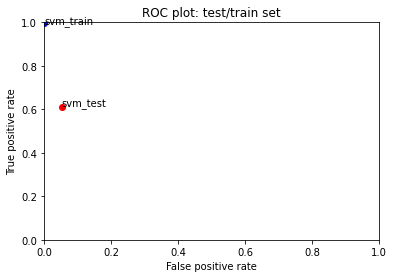

In [58]:
fits = [svm_performance_train, svm_performance_test]

plt.plot(fits[0].performance_measures['FP'] / fits[0].performance_measures['Neg'], 
fits[0].performance_measures['TP'] / fits[0].performance_measures['Pos'], 'bo',
fits[1].performance_measures['FP'] / fits[1].performance_measures['Neg'], 
fits[1].performance_measures['TP'] / fits[1].performance_measures['Pos'], 'ro')

for fit in fits:
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
plt.axis([0,1 , 0, 1])
plt.title('ROC plot: test/train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclaim_count
0          72          10              0
1          13           1              0
2          16           0              0
3          38           3              0
4           7           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49211955812070723


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count,exclaim_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,False
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,False
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission_iteration1.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation